# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Hack SSL error from torchvision datasets
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Constants
CIFAR10_DIR = 'cifar10_dataset'

In [4]:
# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10(
    root=CIFAR10_DIR + '/train', 
    train=True,
    # transform=train_transforms,
    transform=transforms.ToTensor(),
    download=True,
    )

test_data = torchvision.datasets.CIFAR10(
    root=CIFAR10_DIR + '/test', 
    train=False,
    # transform=test_transforms,
    transform=transforms.ToTensor(),
    download=True,
    )

# Create test set and define test dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=256)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_dataset/train/cifar-10-python.tar.gz to cifar10_dataset/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_dataset/test/cifar-10-python.tar.gz to cifar10_dataset/test


In [5]:
print(f"The size of the training data is {len(train_data)}.")
print(f"The size of the test data is {len(test_data)}.")

The size of the training data is 50000.
The size of the test data is 10000.


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

dog


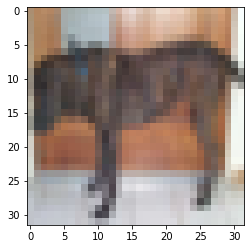

truck


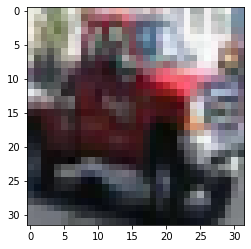

truck


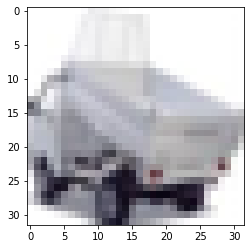

plane


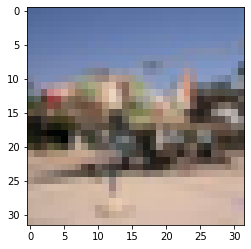

frog


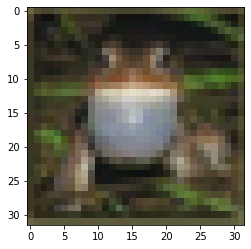

In [7]:
# Explore data
show5(trainloader)

In [8]:
img, label = train_data[0]
print(f"The shape of an image tensor is {img.shape}.")

The shape of an image tensor is torch.Size([3, 32, 32]).


images.shape: torch.Size([128, 3, 32, 32])


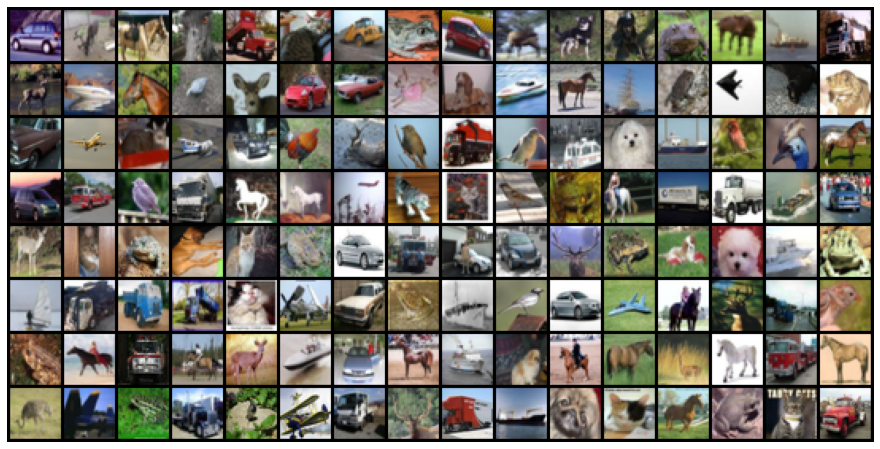

In [9]:
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [15]:
# Hyperparameters for our network
input_size = 3*32*32
hidden_sizes = [1536, 768, 384, 128]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.Softmax(dim=1)
                      )

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [30]:
epochs = 250

train_losses = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        images = images.view(images.shape[0], -1)

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        train_losses.append(running_loss/len(trainloader))
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: -0.4394829703109039
Training loss: -0.4396908558390634
Training loss: -0.44293185367303733
Training loss: -0.44402581621009063
Training loss: -0.44369035212280195
Training loss: -0.44515214368815315
Training loss: -0.4460408014562124
Training loss: -0.4468770501253855
Training loss: -0.44622828054915914
Training loss: -0.44704066518017704
Training loss: -0.4488583397682366
Training loss: -0.44981558060707033
Training loss: -0.44994806938464077
Training loss: -0.4548597707010596
Training loss: -0.45390164440550157
Training loss: -0.45046487679261993
Training loss: -0.45546199743400145
Training loss: -0.4547624560573217
Training loss: -0.45449469796836833
Training loss: -0.4595911352683211
Training loss: -0.4568472750808882
Training loss: -0.45945121123052923
Training loss: -0.45924681158321895
Training loss: -0.460905847342118
Training loss: -0.46075122595748025
Training loss: -0.46218941827564286
Training loss: -0.4661626599328902
Training loss: -0.46362173778321736
Trai

Plot the training loss (and validation loss/accuracy, if recorded).

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

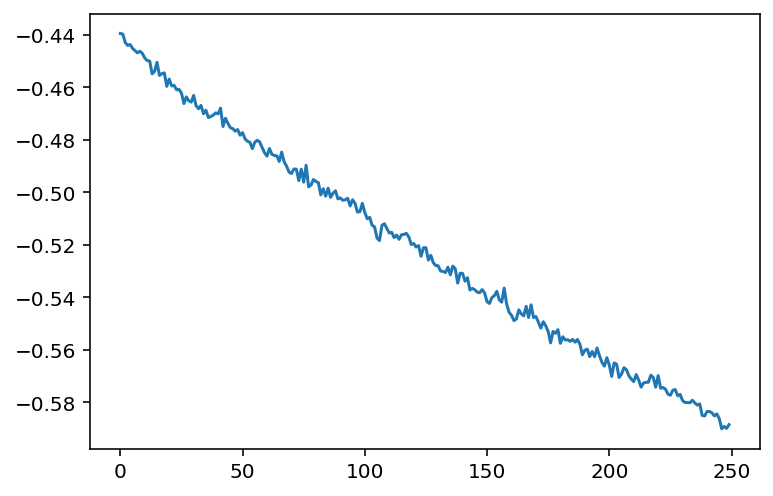

In [32]:
plt.plot(train_losses, label='Training loss')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [33]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        images = images.view(images.shape[0], -1)

        logps = model.forward(images)
        batch_loss = criterion(logps, labels)
        
        test_loss += batch_loss.item()
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test loss: {test_loss/len(testloader):.3f}.. ")
print(f"Test accuracy: {100 * accuracy/len(testloader):.3f}%")

Test loss: -0.452.. 
Test accuracy: 45.166%


## Saving your model
Using `torch.save`, save your model for future loading.

In [34]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Based on the initial results, I'd suggest building an in-house solution rather than buying it from Detectocorp. Although our model is currently 45% accurate, it can be improved faster. Note that this was our first try. By increasing the number of layers and tuning the hyperparameters, I believe we can achive much better results, at lease at the level of Detectocorp. On the other hand, our model as well as Detectocorp's model are far behind the current solutions in the literature. 

Our model consists of 3 hidden layers. Compared to the sophisticated algorithms in the literature, it is pretty small network but it produces promising results. Note that we use the negative log likelihood as our loss function and stochastic gradient descent as our optimizer. 

Like I mentioned above, increasing the number of hidden layers (possibly with different activation functions), tuning the hyperparameters (e.g. learning rate), trying different loss functions and optimizers would help us increase the accuracy. 



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).